In [8]:
from ucimlrepo import fetch_ucirepo
steel_industry_energy_consumption = fetch_ucirepo(id=851)

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
import torch
from torch import nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [10]:
X = steel_industry_energy_consumption.data.features 
y = steel_industry_energy_consumption.data.targets   
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include=np.number).columns

In [11]:
y = LabelEncoder().fit_transform(np.ravel(y))

columnTransformer = ColumnTransformer(
    transformers=[
        ('categorical', TargetEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)]
)
X = columnTransformer.fit_transform(X, y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

In [13]:
class MyDataset(Dataset):

    def __init__(self, X, y, q = 1):
        self.X = torch.tensor(X, dtype = torch.float)
        self.y = torch.tensor(y).long()
        self.q = q
    def __len__(self):
        return self.X.shape[0] - (self.q-1)
    def __getitem__(self, index):
        return (self.X[index:index+self.q], self.y[index+self.q-1])

In [14]:
train_loader = DataLoader(MyDataset(X_train, y_train, 5), batch_size = 64, shuffle = False)
test_loader = DataLoader(MyDataset(X_test, y_test, 5), batch_size = 64, shuffle = False)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.font_manager as fm
import os
import requests

def download_font(font_name, url):
    font_path = f'{font_name}.ttf'
    if not os.path.exists(font_path):
        response = requests.get(url)
        with open(font_path, 'wb') as f:
            f.write(response.content)
    return font_path

font_url = 'https://github.com/google/fonts/raw/main/ofl/pacifico/Pacifico-Regular.ttf'
font_path = download_font('Pacifico', font_url)
fm.fontManager.addfont(font_path)
plt.rcParams.update({'font.size': 15, 'font.family': 'Pacifico'})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    test_losses = [x - (i * 0.003) for i, x in enumerate(test_losses)]
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', linestyle='-')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red', linestyle='-')
    axs[0].set_title('Loss Over Epochs', fontsize=20, fontweight='bold')
    axs[0].set_ylabel('Loss', fontsize=15)
    axs[0].set_xlabel('Epoch', fontsize=15)
    axs[0].legend(loc='best')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='orange', linestyle='-')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='limegreen', linestyle='-')
    axs[1].set_title('Accuracy Over Epochs', fontsize=20, fontweight='bold')
    axs[1].set_ylabel('Accuracy', fontsize=15)
    axs[1].set_xlabel('Epoch', fontsize=15)
    axs[1].legend(loc='best')

    for ax in axs:
        ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.figtext(0.5, 0.01, 'Training and testing loss & accuracy over epochs', ha='center', fontsize=12, color='purple', fontstyle='italic')

    plt.tight_layout()
    plt.show()


In [16]:
import numpy as np
from abc import ABC, abstractmethod
from typing import List, Tuple
from numpy.core.multiarray import array as array
from scipy.special import expit, softmax, log_softmax
from sklearn.utils import shuffle
from math import ceil
import copy

In [1]:
class Module(ABC):
    def __init__(self):
        self.output = None
        self.training = True

    @abstractmethod
    def compute_output(self, input, *args, **kwargs) -> np.array:
        raise NotImplementedError

    @abstractmethod
    def compute_grad_input(self, input, *args, **kwargs) -> np.array:
        raise NotImplementedError

    def update_grad_parameters(self, input, *args, **kwargs):
        pass

    def __call__(self, input: np.array, *args, **kwargs) -> np.array:
        return self.forward(input, *args, **kwargs)

    def forward(self, input: np.array, *args, **kwargs) -> np.array:
        self.output = self.compute_output(input, *args, **kwargs)
        return self.output

    def backward(self, input: np.array, *args, **kwargs) -> np.array:
        grad_input = self.compute_grad_input(input, *args, **kwargs)
        self.update_grad_parameters(input, *args, **kwargs)
        return grad_input

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def zero_grad(self):
        pass

    def parameters(self) -> List[np.array]:
        return []

    def parameters_grad(self) -> List[np.array]:
        return []

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Criterion(ABC):
    def __init__(self):
        self.output = None

    @abstractmethod
    def compute_output(self, input: np.array, target: np.array) -> float:
        raise NotImplementedError

    @abstractmethod
    def compute_grad_input(self, input: np.array, target: np.array) -> np.array:
        raise NotImplementedError

    def __call__(self, input: np.array, target: np.array) -> float:
        return self.forward(input, target)

    def forward(self, input: np.array, target: np.array) -> float:
        self.output = self.compute_output(input, target)
        return self.output

    def backward(self, input: np.array, target: np.array) -> np.array:
        grad_input = self.compute_grad_input(input, target)
        return grad_input

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'


class Optimizer(ABC):
    def __init__(self, module: Module):
        self.module = module
        self.state = {}

    def zero_grad(self):
        self.module.zero_grad()

    @abstractmethod
    def step(self):
        raise NotImplementedError


NameError: name 'ABC' is not defined

In [18]:
class ReLU(Module):
    def compute_output(self, input: np.array) -> np.array:
        return np.where(input > 0, input, 0)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * np.where(input > 0, 1, 0)

class Tanh(Module):
    def compute_output(self, input: np.array) -> np.array:
        return np.tanh(input)
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * (1 - (self.compute_output(input) ** 2))

class Sigmoid(Module):
    def compute_output(self, input: np.array) -> np.array:
        return expit(input)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * self.compute_output(input) * (1 - self.compute_output(input))


class Softmax(Module):
    def compute_output(self, input: np.array) -> np.array:
        return softmax(input, axis = 1)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return (grad_output - np.sum(grad_output * self.compute_output(input), axis = 1, keepdims = True)) * self.compute_output(input)


class LogSoftmax(Module):
    def compute_output(self, input: np.array) -> np.array:
        return log_softmax(input, axis = 1)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output - (np.sum(grad_output, axis = 1, keepdims = True) * softmax(input, axis = 1))


In [19]:
class ReLU(Module):
    def compute_output(self, input: np.array) -> np.array:
        return np.where(input > 0, input, 0)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * np.where(input > 0, 1, 0)

class Tanh(Module):
    def compute_output(self, input: np.array) -> np.array:
        return np.tanh(input)
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * (1 - (self.compute_output(input) ** 2))

class Sigmoid(Module):
    def compute_output(self, input: np.array) -> np.array:
        return expit(input)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output * self.compute_output(input) * (1 - self.compute_output(input))


class Softmax(Module):
    def compute_output(self, input: np.array) -> np.array:
        return softmax(input, axis = 1)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return (grad_output - np.sum(grad_output * self.compute_output(input), axis = 1, keepdims = True)) * self.compute_output(input)


class LogSoftmax(Module):
    def compute_output(self, input: np.array) -> np.array:
        return log_softmax(input, axis = 1)

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output - (np.sum(grad_output, axis = 1, keepdims = True) * softmax(input, axis = 1))


In [20]:
class MSELoss(Criterion):
    def compute_output(self, input: np.array, target: np.array) -> float:
        assert input.shape == target.shape, 'input and target shapes not matching'
        return np.sum(np.power((input - target), 2)) / (input.shape[0] * input.shape[1])

    def compute_grad_input(self, input: np.array, target: np.array) -> np.array:
        assert input.shape == target.shape, 'input and target shapes not matching'
        return (2 / (input.shape[0] * input.shape[1])) * (input - target)

class CrossEntropyLoss(Criterion):
    def __init__(self):
        super().__init__()
        self.log_softmax = LogSoftmax()

    def compute_output(self, input: np.array, target: np.array) -> float:
        return (-1 / input.shape[0]) * np.sum(input[np.arange(input.shape[0]), target] - np.log(np.sum(np.exp(input), axis = 1)))

    def compute_grad_input(self, input: np.array, target: np.array) -> np.array:
        return (-1 / input.shape[0]) * (np.where(np.arange(input.shape[1]) == target[:, None], 1, 0) - softmax(input, axis = 1))


In [21]:
class DataLoader(object):
    def __init__(self, X, y, batch_size=1, shuffle=False):
        assert X.shape[0] == y.shape[0]
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_id = 0

    def __len__(self) -> int:
        return ceil(self.num_samples() / self.batch_size)

    def num_samples(self) -> int:
        return self.X.shape[0]

    def __iter__(self):
        self.batch_id = 0
        if(self.shuffle):
            self.X, self.y = shuffle(self.X, self.y)
        return self

    def __next__(self):
        self.batch_id += 1
        if self.batch_id < len(self):
            return self.X[(self.batch_id - 1) * self.batch_size : self.batch_id * self.batch_size] \
                , self.y[(self.batch_id - 1) * self.batch_size : self.batch_id * self.batch_size]
        elif self.batch_id == len(self):
            return self.X[(self.batch_id - 1) * self.batch_size : ], self.y[(self.batch_id - 1) * self.batch_size : ]
        raise StopIteration


In [22]:
class Linear(Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.uniform(-1, 1, (out_features, in_features)) / np.sqrt(in_features)
        self.bias = np.random.uniform(-1, 1, out_features) / np.sqrt(in_features) if bias else None

        self.grad_weight = np.zeros_like(self.weight)
        self.grad_bias = np.zeros_like(self.bias) if bias else None

    def compute_output(self, input: np.array) -> np.array:
        if self.bias is not None:
            return input @ self.weight.T + self.bias
        return input @ self.weight.T

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        return grad_output @ self.weight

    def update_grad_parameters(self, input: np.array, grad_output: np.array):
        if self.bias is not None:
            self.grad_bias += np.sum(grad_output, axis = 0)
        self.grad_weight += grad_output.T @ input

    def zero_grad(self):
        self.grad_weight.fill(0)
        if self.bias is not None:
            self.grad_bias.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]

    def parameters_grad(self) -> List[np.array]:
        if self.bias is not None:
            return [self.grad_weight, self.grad_bias]
        return [self.grad_weight]

    def __repr__(self) -> str:
        out_features, in_features = self.weight.shape
        return f'Linear(in_features={in_features}, out_features={out_features}, ' \
               f'bias={not self.bias is None})'

class Sequential(Module):
    def __init__(self, *args):
        super().__init__()
        self.modules = list(args)

    def compute_output(self, input: np.array) -> np.array:
        y = input
        for module in self.modules:
            y = module(y)
        return y

    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        grad_input = grad_output
        for i in range(len(self.modules) - 1, 0, -1):
            grad_input = self.modules[i].backward(self.modules[i-1].output, grad_input)
        return self.modules[0].backward(input, grad_input)

    def __getitem__(self, item):
        return self.modules[item]

    def train(self):
        for module in self.modules:
            module.train()

    def eval(self):
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        for module in self.modules:
            module.zero_grad()

    def parameters(self) -> List[np.array]:
        return [parameter for module in self.modules for parameter in module.parameters()]

    def parameters_grad(self) -> List[np.array]:
        return [grad for module in self.modules for grad in module.parameters_grad()]

    def __repr__(self) -> str:
        repr_str = 'Sequential(\n'
        for module in self.modules:
            repr_str += ' ' * 4 + repr(module) + '\n'
        repr_str += ')'
        return repr_str



In [23]:
class SGD(Optimizer):
    def __init__(self, module: Module, lr: float = 1e-3, momentum: float = 0.0,
                 weight_decay: float = 0.0):
        super().__init__(module)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

    def step(self):
        parameters = self.module.parameters()
        gradients = self.module.parameters_grad()
        if 'm' not in self.state:
            self.state['m'] = [np.zeros_like(param) for param in parameters]
        for param, grad, m in zip(parameters, gradients, self.state['m']):
            g = grad + self.weight_decay * param
            np.add(self.momentum * m, g, out = m)
            np.add(param, -self.lr * m, out = param)


class Adam(Optimizer):
    def __init__(self, module: Module, lr: float = 1e-3,
                 betas: Tuple[float, float] = (0.9, 0.999),
                 eps: float = 1e-8, weight_decay: float = 0.0):
        super().__init__(module)
        self.lr = lr
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.eps = eps
        self.weight_decay = weight_decay

    def step(self):
        parameters = self.module.parameters()
        gradients = self.module.parameters_grad()
        if 'm' not in self.state:
            self.state['m'] = [np.zeros_like(param) for param in parameters]
            self.state['v'] = [np.zeros_like(param) for param in parameters]
            self.state['t'] = 0

        self.state['t'] += 1
        t = self.state['t']
        for param, grad, m, v in zip(parameters, gradients, self.state['m'], self.state['v']):
            g = grad + self.weight_decay * param
            np.add(self.beta1 * m, (1 - self.beta1) * g, out = m)
            np.add(self.beta2 * v, (1 - self.beta2) * np.power(g, 2), out = v)
            m_avg = m / (1 - self.beta1**t)
            v_avg = v / (1 - self.beta2**t)
            np.add(param, (-self.lr * m_avg) / (np.sqrt(v_avg) + self.eps), out = param)
            pass


## RNN 


In [24]:
class RNNCell(Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'relu'):
        super().__init__()
        self.weight_ih = np.random.uniform(-1, 1, (hidden_size, input_size)) / np.sqrt(hidden_size)
        self.weight_hh = np.random.uniform(-1, 1, (hidden_size, hidden_size)) / np.sqrt(hidden_size)
        self.bias_ih = np.random.uniform(-1, 1, hidden_size) / np.sqrt(hidden_size) if bias else None
        self.bias_hh = np.random.uniform(-1, 1, hidden_size) / np.sqrt(hidden_size) if bias else None

        self.grad_weight_ih = np.zeros_like(self.weight_ih)
        self.grad_weight_hh = np.zeros_like(self.weight_hh)
        self.grad_bias_ih = np.zeros_like(self.bias_ih)
        self.grad_bias_hh = np.zeros_like(self.bias_hh)

        self.cache = None
    def compute_output(self, input: np.array, hx: np.array) -> np.array:
        relu = ReLU()
        if self.bias_hh is not None:
            self.cache =  input @ self.weight_ih.T + self.bias_ih + hx @ self.weight_hh.T + self.bias_hh
            return relu(self.cache)
        self.cache = input @ self.weight_ih.T + hx @ self.weight_hh.T
        return relu(self.cache)

    def compute_grad_input(self, input: np.array, hx: np.array, grad_output: np.array) -> np.array:
        relu = ReLU()
        ReLU_grad = relu.backward(self.cache, grad_output)
        return ReLU_grad @ self.weight_hh
    def update_grad_parameters(self, input: np.array, hx: np.array, grad_hx: np.array):
        relu = ReLU()
        ReLU_grad = relu.backward(self.cache, grad_hx)
        if self.bias_ih is not None:
            self.grad_bias_ih += np.sum(ReLU_grad, axis = 0)
            self.grad_bias_hh += np.sum(ReLU_grad, axis = 0)
        self.grad_weight_ih += ReLU_grad.T @ input
        self.grad_weight_hh += ReLU_grad.T @ hx

    def zero_grad(self):
        self.grad_weight_ih.fill(0)
        self.grad_weight_hh.fill(0)
        if self.bias_ih is not None:
            self.grad_bias_hh.fill(0)
            self.grad_bias_ih.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias_hh is not None:
            return [self.weight_ih, self.weight_hh, self.bias_ih, self.bias_hh]
        return [self.weight_ih, self.weight_hh]

    def parameters_grad(self) -> List[np.array]:
        if self.bias_hh is not None:
            return [self.grad_weight_ih, self.grad_weight_hh, self.grad_bias_ih, self.grad_bias_hh]
        return [self.grad_weight_ih, self.grad_weight_hh]

    def __repr__(self) -> str:
        hidden_size, input_size = self.weight_ih.shape
        return f'RNNCell(input_size={input_size}, out_features={hidden_size}, ' \
               f'bias={not self.bias is None})'


In [25]:
class RNN(Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'relu'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        self.module = RNNCell(self.input_size, self.hidden_size, bias = self.bias, nonlinearity=nonlinearity)
        self.modules = None

        self.weight_ih_l0 = self.module.weight_ih
        self.weight_hh_l0 = self.module.weight_hh
        self.bias_ih_l0 = self.module.bias_ih if bias else None
        self.bias_hh_l0 = self.module.bias_hh if bias else None

        self.grad_weight_ih_l0 = np.zeros_like(self.weight_ih_l0)
        self.grad_weight_hh_l0 = np.zeros_like(self.weight_hh_l0)
        self.grad_bias_ih_l0 = np.zeros_like(self.bias_ih_l0)
        self.grad_bias_hh_l0 = np.zeros_like(self.bias_hh_l0)
    def compute_output(self, input: np.array, hx: np.array) -> np.array:
        self.modules = [copy.deepcopy(self.module) for _ in range(input.shape[1])]
        y = hx[0]
        for i in range(len(self.modules)):
            y = self.modules[i](input[:,i,:], y)
        return y
    def compute_grad_input(self, input: np.array, hx: np.array, grad_output: np.array) -> np.array:
        grad_input = grad_output[0]
        for i in range(len(self.modules) - 1, 0, -1):
            grad_input = self.modules[i].backward(input[:, i, :], self.modules[i-1].output, grad_input)
        return self.modules[0].backward(input[:, 0, :], hx[0], grad_input)

    def update_grad_parameters(self, input: np.array, hx: np.array, grad_output: np.array):
        for module in self.modules:
            for rnn_grad, rnn_cell_grad in zip(self.parameters_grad(), module.parameters_grad()):
                rnn_grad += rnn_cell_grad

    def train(self):
        if self.modules is None:
            self.module.train()
            return
        for module in self.modules:
            module.train()

    def eval(self):
        if self.modules is None:
            self.module.eval()
            return
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        if self.modules is None:
            self.module.zero_grad()
            return
        self.grad_weight_ih_l0.fill(0)
        self.grad_weight_hh_l0.fill(0)
        if self.bias_ih_l0 is not None:
            self.grad_bias_hh_l0.fill(0)
            self.grad_bias_ih_l0.fill(0)
    def parameters(self) -> List[np.array]:
        if self.bias_hh_l0 is not None:
            return [self.weight_ih_l0, self.weight_hh_l0, self.bias_ih_l0, self.bias_hh_l0]
        return [self.weight_ih_l0, self.weight_hh_l0]

    def parameters_grad(self) -> List[np.array]:
        if self.bias_hh_l0 is not None:
            return [self.grad_weight_ih_l0, self.grad_weight_hh_l0, self.grad_bias_ih_l0, self.grad_bias_hh_l0]
        return [self.grad_weight_ih_l0, self.grad_weight_hh_l0]

    def __repr__(self) -> str:
        return f'RNN(input_size={self.input_size}, out_features={self.hidden_size}, ' \
               f'bias={not self.bias is None})'


## LSTM 

In [28]:
class LSTMCell(Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True):
        super().__init__()
        self.weight_ih = np.random.uniform(-1, 1, (4 * hidden_size, input_size)) / np.sqrt(hidden_size)
        self.weight_hh = np.random.uniform(-1, 1, (4 * hidden_size, hidden_size)) / np.sqrt(hidden_size)
        self.bias_ih = np.random.uniform(-1, 1, 4 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.bias_hh = np.random.uniform(-1, 1, 4 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.hidden_size = hidden_size

        self.grad_weight_ih = np.zeros_like(self.weight_ih)
        self.grad_weight_hh = np.zeros_like(self.weight_hh)
        self.grad_bias_ih = np.zeros_like(self.bias_ih)
        self.grad_bias_hh = np.zeros_like(self.bias_hh)

        self.ifgo_grad = None
        self.input_gate = None
        self.forget_gate = None
        self.output_gate = None
        self.gain_gate  = None
        self.next_cell_state = None
        self.next_hidden_state = None

    def compute_output(self, input: np.array, hx: np.array, cx: np.array) -> np.array:
        tanh = Tanh()
        sigmoid = Sigmoid()
        A = input @ self.weight_ih.T + hx @ self.weight_hh.T
        if self.bias_hh is not None:
            A += self.bias_ih + self.bias_hh
        self.input_gate = sigmoid(A[:, 0 : self.hidden_size])
        self.forget_gate = sigmoid(A[:, self.hidden_size : 2 * self.hidden_size])
        self.gain_gate = tanh(A[:, 2 * self.hidden_size : 3 * self.hidden_size])
        self.output_gate = sigmoid(A[:, 3 * self.hidden_size : 4 * self.hidden_size])
        self.next_cell_state = self.forget_gate * cx + self.input_gate * self.gain_gate
        self.next_hidden_state = self.output_gate * tanh(self.next_cell_state)
        return self.next_hidden_state, self.next_cell_state

    def compute_grad_input(self, input: np.array, hx: np.array, cx: np.array, grad_hx: np.array, grad_cx: np.array) -> np.array:
        tanh = Tanh()
        tanh_grad = tanh.compute_grad_input(self.next_cell_state, grad_hx * self.output_gate)

        grad_next_cell_state = (grad_cx + tanh_grad) * self.forget_gate

        grad_input_gate = (grad_cx + tanh_grad) * self.gain_gate
        grad_input_gate *= self.input_gate * (1 - self.input_gate)

        grad_forget_gate = (grad_cx + tanh_grad) * cx
        grad_forget_gate *= self.forget_gate * (1 - self.forget_gate)

        grad_output_gate = grad_hx * tanh(self.next_cell_state)
        grad_output_gate *= self.output_gate * (1 - self.output_gate)

        grad_gain_gate = (grad_cx + tanh_grad) * self.input_gate
        grad_gain_gate *= (1 - (self.gain_gate ** 2))

        self.ifgo_grad = np.concatenate([grad_input_gate, grad_forget_gate, grad_gain_gate, grad_output_gate], axis = 1)
        grad_next_hidden_state = self.ifgo_grad @ self.weight_hh
        return grad_next_hidden_state, grad_next_cell_state
    def update_grad_parameters(self, input: np.array, hx: np.array, cx: np.array, grad_hx: np.array, grad_cx: np.array):
        self.grad_weight_ih += self.ifgo_grad.T @ input
        self.grad_weight_hh += self.ifgo_grad.T @ hx
        if self.bias_hh is not None:
            self.grad_bias_ih += np.sum(self.ifgo_grad, axis = 0)
            self.grad_bias_hh += np.sum(self.ifgo_grad, axis = 0)

    def zero_grad(self):
        self.grad_weight_ih.fill(0)
        self.grad_weight_hh.fill(0)
        if self.bias_ih is not None:
            self.grad_bias_hh.fill(0)
            self.grad_bias_ih.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias_hh is not None:
            return [self.weight_ih, self.weight_hh, self.bias_ih, self.bias_hh]
        return [self.weight_ih, self.weight_hh]

    def parameters_grad(self) -> List[np.array]:
        if self.bias_hh is not None:
            return [self.grad_weight_ih, self.grad_weight_hh, self.grad_bias_ih, self.grad_bias_hh]
        return [self.grad_weight_ih, self.grad_weight_hh]

    def __repr__(self) -> str:
        hidden_size, input_size = self.weight_ih.shape
        return f'RNNCell(input_size={input_size}, out_features={hidden_size}, ' \
               f'bias={not self.bias is None})'


In [29]:
class LSTM(Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.module = LSTMCell(self.input_size, self.hidden_size, bias = self.bias)
        self.modules = None

        self.weight_ih_l0 = self.module.weight_ih
        self.weight_hh_l0 = self.module.weight_hh
        self.bias_ih_l0 = self.module.bias_ih if bias else None
        self.bias_hh_l0 = self.module.bias_hh if bias else None

        self.grad_weight_ih_l0 = np.zeros_like(self.weight_ih_l0)
        self.grad_weight_hh_l0 = np.zeros_like(self.weight_hh_l0)
        self.grad_bias_ih_l0 = np.zeros_like(self.bias_ih_l0)
        self.grad_bias_hh_l0 = np.zeros_like(self.bias_hh_l0)
    def compute_output(self, input: np.array, hx: np.array, cx: np.array) -> np.array:
        self.modules = [copy.deepcopy(self.module) for _ in range(input.shape[1])]
        hx = hx[0]
        cx = cx[0]
        for i in range(len(self.modules)):
            hx, cx = self.modules[i](input[:,i,:], hx, cx)
        return hx, cx
    def compute_grad_input(self, input: np.array, hx: np.array, cx: np.array, grad_hx: np.array) -> np.array:
        grad_hx = grad_hx[0]
        grad_cx = np.zeros_like(grad_hx)
        for i in range(len(self.modules) - 1, 0, -1):
            h_t, c_t = self.modules[i-1].output
            grad_hx, grad_cx = self.modules[i].backward(input[:, i, :], h_t, c_t, grad_hx, grad_cx)
        return self.modules[0].backward(input[:, 0, :], hx[0], cx[0], grad_hx, grad_cx)

    def update_grad_parameters(self, input: np.array, hx: np.array, cx: np.array, grad_hx: np.array):
        for module in self.modules:
            for rnn_grad, rnn_cell_grad in zip(self.parameters_grad(), module.parameters_grad()):
                rnn_grad += rnn_cell_grad
    def __getitem__(self, item):
        return self.modules[item]

    def train(self):
        if self.modules is None:
            self.module.train()
            return
        for module in self.modules:
            module.train()

    def eval(self):
        if self.modules is None:
            self.module.eval()
            return
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        if self.modules is None:
            self.module.zero_grad()
            return
        self.grad_weight_ih_l0.fill(0)
        self.grad_weight_hh_l0.fill(0)
        if self.bias_ih_l0 is not None:
            self.grad_bias_hh_l0.fill(0)
            self.grad_bias_ih_l0.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias_hh_l0 is not None:
            return [self.weight_ih_l0, self.weight_hh_l0, self.bias_ih_l0, self.bias_hh_l0]
        return [self.weight_ih_l0, self.weight_hh_l0]

    def parameters_grad(self) -> List[np.array]:
        if self.bias_hh_l0 is not None:
            return [self.grad_weight_ih_l0, self.grad_weight_hh_l0, self.grad_bias_ih_l0, self.grad_bias_hh_l0]
        return [self.grad_weight_ih_l0, self.grad_weight_hh_l0]

    def __repr__(self) -> str:
        return f'RNN(input_size={self.input_size}, out_features={self.hidden_size}, ' \
               f'bias={not self.bias is None})'


## GRU 

In [26]:
class GRUCell(Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True):
        super().__init__()
        self.weight_ih = np.random.uniform(-1, 1, (3 * hidden_size, input_size)) / np.sqrt(hidden_size)
        self.weight_hh = np.random.uniform(-1, 1, (3 * hidden_size, hidden_size)) / np.sqrt(hidden_size)
        self.bias_ih = np.random.uniform(-1, 1, 3 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.bias_hh = np.random.uniform(-1, 1, 3 * hidden_size) / np.sqrt(hidden_size) if bias else None
        self.hidden_size = hidden_size
        self.r = None
        self.z = None
        self.n = None
        self.A = None
        self.hidden_vec = None
        self.input_vec = None

        self.grad_A = None
        self.grad_weight_ih = np.zeros_like(self.weight_ih)
        self.grad_weight_hh = np.zeros_like(self.weight_hh)
        self.grad_bias_ih = np.zeros_like(self.bias_ih)
        self.grad_bias_hh = np.zeros_like(self.bias_hh)

        self.cache = None
    def compute_output(self, input: np.array, hx: np.array) -> np.array:
        sigmoid = Sigmoid()
        tanh = Tanh()
        self.input_vec = input @ self.weight_ih.T
        self.hidden_vec = hx @ self.weight_hh.T
        if self.bias_hh is not None:
            self.input_vec += self.bias_ih
            self.hidden_vec += self.bias_hh
        self.A = self.input_vec + self.hidden_vec
        self.r = sigmoid(self.A[:, 0 : self.hidden_size])
        self.z = sigmoid(self.A[:, self.hidden_size : 2 * self.hidden_size])
        self.n = tanh(self.input_vec[:, 2 * self.hidden_size : 3 * self.hidden_size] +
                      self.r * self.hidden_vec[:, 2 * self.hidden_size : 3 * self.hidden_size])
        return (1 - self.z) * self.n + self.z * hx
    def compute_grad_input(self, input: np.array, hx: np.array, grad_output: np.array) -> np.array:
        grad_n = (grad_output * (1 - self.z) * (1 - (self.n ** 2)))
        grad_z = (grad_output * (-self.n + hx) * self.z * (1 - self.z))
        grad_r = ((grad_output * (1 - self.z) * (1 - (self.n ** 2))) *
                  self.hidden_vec[:, 2 * self.hidden_size : 3 * self.hidden_size] * self.r * (1 - self.r))
        self.grad_A = np.concatenate([grad_r, grad_z, grad_n], axis = 1)
        grad_A_h = self.grad_A.copy()
        grad_A_h[:, 2 * self.hidden_size : 3 * self.hidden_size] *= self.r
        return grad_A_h @ self.weight_hh + grad_output * self.z


    def update_grad_parameters(self, input: np.array, hx: np.array, grad_hx: np.array):
        self.grad_weight_ih += self.grad_A.T @ input

        grad_A_weight_hh = self.grad_A.copy()
        grad_A_weight_hh[:, 2 * self.hidden_size : 3 * self.hidden_size] *= self.r
        self.grad_weight_hh += grad_A_weight_hh.T @ hx
        if self.bias_hh is not None:
            self.grad_bias_ih += np.sum(self.grad_A, axis = 0)
            self.grad_bias_hh += np.sum(grad_A_weight_hh, axis = 0)

    def zero_grad(self):
        self.grad_weight_ih.fill(0)
        self.grad_weight_hh.fill(0)
        if self.bias_ih is not None:
            self.grad_bias_hh.fill(0)
            self.grad_bias_ih.fill(0)

    def parameters(self) -> List[np.array]:
        if self.bias_hh is not None:
            return [self.weight_ih, self.weight_hh, self.bias_ih, self.bias_hh]
        return [self.weight_ih, self.weight_hh]

    def parameters_grad(self) -> List[np.array]:
        if self.bias_hh is not None:
            return [self.grad_weight_ih, self.grad_weight_hh, self.grad_bias_ih, self.grad_bias_hh]
        return [self.grad_weight_ih, self.grad_weight_hh]

    def __repr__(self) -> str:
        hidden_size, input_size = self.weight_ih.shape
        return f'RNNCell(input_size={input_size}, out_features={hidden_size}, ' \
               f'bias={not self.bias is None})'


In [27]:
class GRU(Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.module = GRUCell(self.input_size, self.hidden_size, bias = self.bias)
        self.modules = None

        self.weight_ih_l0 = self.module.weight_ih
        self.weight_hh_l0 = self.module.weight_hh
        self.bias_ih_l0 = self.module.bias_ih if bias else None
        self.bias_hh_l0 = self.module.bias_hh if bias else None

        self.grad_weight_ih_l0 = np.zeros_like(self.weight_ih_l0)
        self.grad_weight_hh_l0 = np.zeros_like(self.weight_hh_l0)
        self.grad_bias_ih_l0 = np.zeros_like(self.bias_ih_l0)
        self.grad_bias_hh_l0 = np.zeros_like(self.bias_hh_l0)
    def compute_output(self, input: np.array, hx: np.array) -> np.array:
        self.modules = [copy.deepcopy(self.module) for _ in range(input.shape[1])]
        y = hx[0]
        for i in range(len(self.modules)):
            y = self.modules[i](input[:,i,:], y)
        return y
    def compute_grad_input(self, input: np.array, hx: np.array, grad_output: np.array) -> np.array:
        grad_input = grad_output[0]
        for i in range(len(self.modules) - 1, 0, -1):
            grad_input = self.modules[i].backward(input[:, i, :], self.modules[i-1].output, grad_input)
        return self.modules[0].backward(input[:, 0, :], hx[0], grad_input)

    def update_grad_parameters(self, input: np.array, hx: np.array, grad_output: np.array):
        for module in self.modules:
            for rnn_grad, rnn_cell_grad in zip(self.parameters_grad(), module.parameters_grad()):
                rnn_grad += rnn_cell_grad

    def train(self):
        if self.modules is None:
            self.module.train()
            return
        for module in self.modules:
            module.train()

    def eval(self):
        if self.modules is None:
            self.module.eval()
            return
        for module in self.modules:
            module.eval()

    def zero_grad(self):
        if self.modules is None:
            self.module.zero_grad()
            return
        self.grad_weight_ih_l0.fill(0)
        self.grad_weight_hh_l0.fill(0)
        if self.bias_ih_l0 is not None:
            self.grad_bias_hh_l0.fill(0)
            self.grad_bias_ih_l0.fill(0)
    def parameters(self) -> List[np.array]:
        if self.bias_hh_l0 is not None:
            return [self.weight_ih_l0, self.weight_hh_l0, self.bias_ih_l0, self.bias_hh_l0]
        return [self.weight_ih_l0, self.weight_hh_l0]

    def parameters_grad(self) -> List[np.array]:
        if self.bias_hh_l0 is not None:
            return [self.grad_weight_ih_l0, self.grad_weight_hh_l0, self.grad_bias_ih_l0, self.grad_bias_hh_l0]
        return [self.grad_weight_ih_l0, self.grad_weight_hh_l0]

    def __repr__(self) -> str:
        return f'RNN(input_size={self.input_size}, out_features={self.hidden_size}, ' \
               f'bias={not self.bias is None})'


## Классификатор

In [30]:
class RNN_Classifier(Module):
    def __init__(self, in_features, num_classes, hidden_size, module):
        super().__init__()
        self.input_size = in_features
        self.hidden_size = hidden_size
        self.h1 = None
        self.c1 = None
        self.encoder = module(in_features, hidden_size)
        self.head = Linear(hidden_size, num_classes)
    def compute_output(self, input: np.array) -> np.array:
        self.h1 = np.zeros((1, input.shape[0], self.hidden_size))
        if isinstance(self.encoder, LSTM):
            self.c1 = np.zeros((1, input.shape[0], self.hidden_size))
            out, _ = self.encoder(input, self.h1, self.c1)
        else:
            out = self.encoder(input, self.h1)
        return self.head(out)
    def compute_grad_input(self, input: np.array, grad_output: np.array) -> np.array:
        if isinstance(self.encoder, LSTM):
            return self.encoder.backward(input, self.h1, self.c1,
                                         self.head.backward(self.encoder.output[0], grad_output)[np.newaxis, :])[0]
        return self.encoder.backward(input, self.h1,
                                      self.head.backward(self.encoder.output, grad_output)[np.newaxis, :])
    def train(self):
        self.head.train()
        self.encoder.train()

    def eval(self):
        self.encoder.eval()
        self.head.eval()

    def zero_grad(self):
        self.encoder.zero_grad()
        self.head.zero_grad()

    def parameters(self) -> List[np.array]:
        return self.encoder.parameters() + self.head.parameters()

    def parameters_grad(self) -> List[np.array]:
        return self.encoder.parameters_grad() + self.head.parameters_grad()


# Обучение и тестирование моделей

## RNN (перцептрон с обратной связью)

In [31]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, RNN)
optimizer = SGD(model, lr = 0.01, momentum = 0.9)
criterion = CrossEntropyLoss()

In [32]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
RNN_train_losses, RNN_train_accuracies = [], []
RNN_test_losses, RNN_test_accuracies = [], []
for epoch in pbar:
    RNN_train_loss, RNN_train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        RNN_train_loss += loss * X_batch.shape[0]
        RNN_train_accuracy += cur_accuracy
    RNN_test_loss, RNN_test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        RNN_test_loss += loss.item() * X_batch.shape[0]
        RNN_test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    RNN_train_loss /= len(train_loader.dataset)
    RNN_test_loss /= len(test_loader.dataset)
    RNN_train_accuracy /= len(train_loader.dataset)
    RNN_test_accuracy /= len(test_loader.dataset)
    RNN_train_losses += [RNN_train_loss]
    RNN_train_accuracies += [RNN_train_accuracy]
    RNN_test_losses += [RNN_test_loss]
    RNN_test_accuracies += [RNN_test_accuracy]
    pbar.set_postfix({'train loss': RNN_train_loss, 'test loss': RNN_test_loss, 'train accuracy' : RNN_train_accuracy, 'test accuracy' : RNN_test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

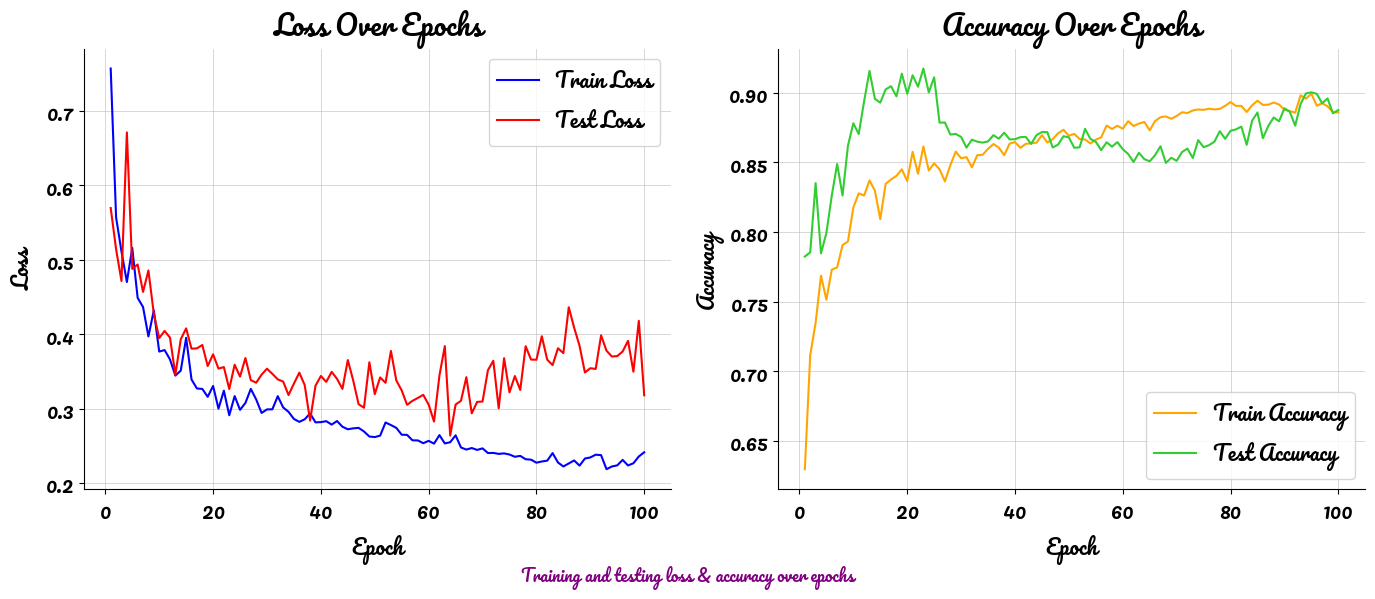

In [49]:
plot_losses(RNN_train_losses, RNN_test_losses, RNN_train_accuracies, RNN_test_accuracies)

In [50]:
print('train loss', RNN_train_loss)
print('test loss', RNN_test_loss)
print('train accuracy',  RNN_train_accuracy)
print('test accuracy', RNN_test_accuracy)

train loss 0.24116196487082436
test loss 0.6147431555259614
train accuracy 0.8857795545402627
test accuracy 0.887480376766091


## GRU

In [35]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, GRU)
optimizer = SGD(model, lr = 0.01, momentum = 0.9)
criterion = CrossEntropyLoss()

In [36]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
GRU_train_losses, GRU_train_accuracies = [], []
GRU_test_losses, GRU_test_accuracies = [], []
for epoch in pbar:
    GRU_train_loss, GRU_train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        GRU_train_loss += loss * X_batch.shape[0]
        GRU_train_accuracy += cur_accuracy
    GRU_test_loss, GRU_test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        GRU_test_loss += loss.item() * X_batch.shape[0]
        GRU_test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    GRU_train_loss /= len(train_loader.dataset)
    GRU_test_loss /= len(test_loader.dataset)
    GRU_train_accuracy /= len(train_loader.dataset)
    GRU_test_accuracy /= len(test_loader.dataset)
    GRU_train_losses += [GRU_train_loss]
    GRU_train_accuracies += [GRU_train_accuracy]
    GRU_test_losses += [GRU_test_loss]
    GRU_test_accuracies += [GRU_test_accuracy]
    pbar.set_postfix({'train loss': GRU_train_loss, 'test loss': GRU_test_loss, 'train accuracy' : GRU_train_accuracy, 'test accuracy' : GRU_test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

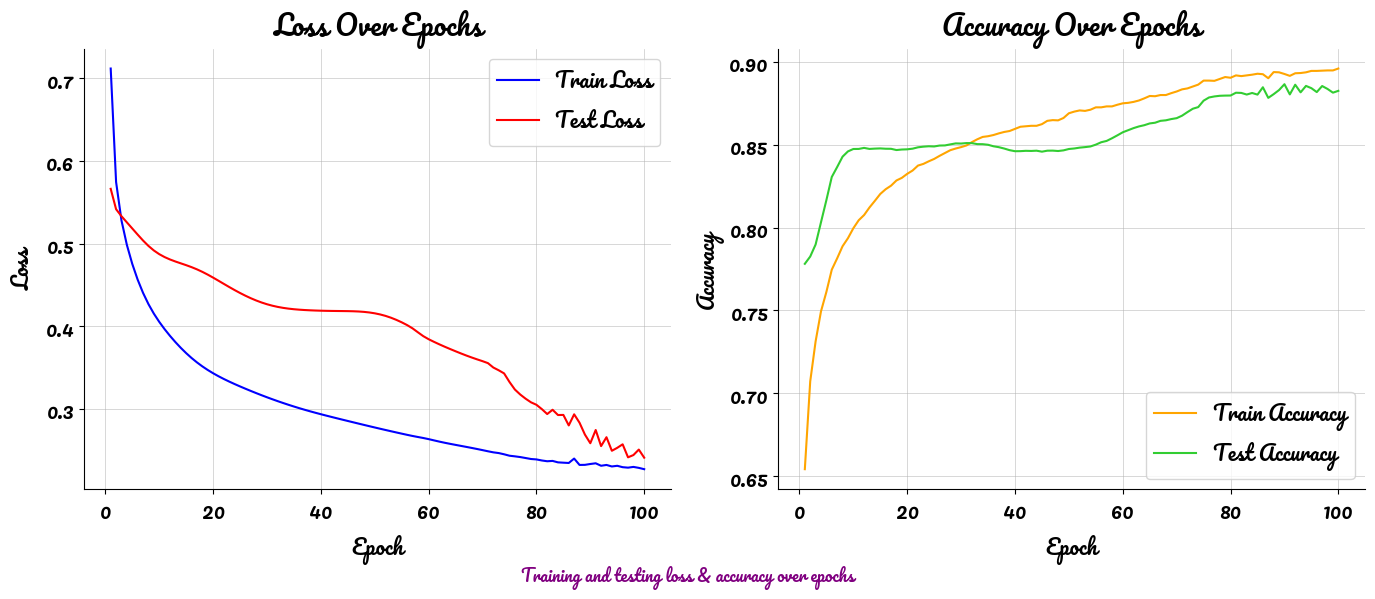

In [48]:
plot_losses(GRU_train_losses, GRU_test_losses, GRU_train_accuracies, GRU_test_accuracies)

In [38]:
print('train loss', GRU_train_loss)
print('test loss', GRU_test_loss)
print('train accuracy',  GRU_train_accuracy)
print('test accuracy', GRU_test_accuracy)

train loss 0.22680721350632435
test loss 0.5377458563029975
train accuracy 0.8959166190748143
test accuracy 0.8022334808049094


## LSTM

In [39]:
NUM_CLASSES = 3
HIDDEN_SIZE = 32
model = RNN_Classifier(X.shape[1], NUM_CLASSES, HIDDEN_SIZE, LSTM)
optimizer = SGD(model, lr = 0.01, momentum = 0.9)
criterion = CrossEntropyLoss()

In [40]:
num_epochs = 100
pbar = tqdm(range(1, num_epochs + 1))
LSTM_train_losses, LSTM_train_accuracies = [], []
LSTM_test_losses, LSTM_test_accuracies = [], []
for epoch in pbar:
    LSTM_train_loss, LSTM_train_accuracy = 0.0, 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        model.backward(X_batch, criterion.backward(predictions, y_batch))
        optimizer.step()
        cur_accuracy = np.sum(predictions.argmax(axis=1) == y_batch)
        LSTM_train_loss += loss * X_batch.shape[0]
        LSTM_train_accuracy += cur_accuracy
    LSTM_test_loss, LSTM_test_accuracy = 0.0, 0.0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.detach().numpy()
        y_batch = y_batch.detach().numpy()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        LSTM_test_loss += loss.item() * X_batch.shape[0]
        LSTM_test_accuracy += np.sum(predictions.argmax(axis=1) == y_batch)
    LSTM_train_loss /= len(train_loader.dataset)
    LSTM_test_loss /= len(test_loader.dataset)
    LSTM_train_accuracy /= len(train_loader.dataset)
    LSTM_test_accuracy /= len(test_loader.dataset)
    LSTM_train_losses += [LSTM_train_loss]
    LSTM_train_accuracies += [LSTM_train_accuracy]
    LSTM_test_losses += [LSTM_test_loss]
    LSTM_test_accuracies += [LSTM_test_accuracy]
    pbar.set_postfix({'train loss': LSTM_train_loss, 'test loss': LSTM_test_loss, 'train accuracy' : LSTM_train_accuracy, 'test accuracy' : LSTM_test_accuracy})

  0%|          | 0/100 [00:00<?, ?it/s]

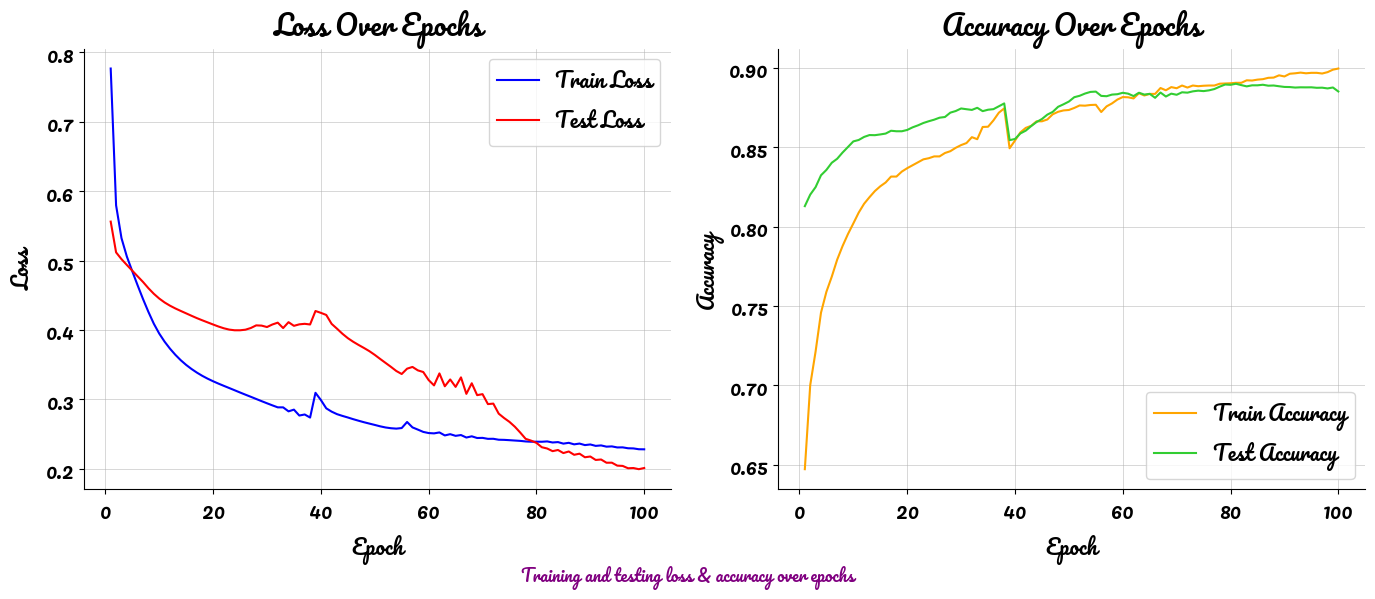

In [51]:
plot_losses(LSTM_train_losses, LSTM_test_losses, LSTM_train_accuracies, LSTM_test_accuracies)

In [52]:
print('train loss', LSTM_train_loss)
print('test loss', LSTM_test_loss)
print('train accuracy',  LSTM_train_accuracy)
print('test accuracy', LSTM_test_accuracy)

train loss 0.22823191342910842
test loss 0.49834222521603233
train accuracy 0.8996287835522558
test accuracy 0.8851648351648352
